# Utilisation des bibliothèques "scientifiques"

Le but de ce deuxième notebook est de mettre en oeuvre les différents modules proposés par la bibliothèque `NumPy` (Numerical Python), `Matplotlib` (pour le tracé des figures) et `SciPy` (Scientific Python).

On commence par importer ces *packages*

In [1]:
# to make the plots appear and be stored within the notebook
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal

## Vectoriser les opérations

Une bonne utilisation de la bibliothèque NumPy consiste à fair le moins de boucles `for` pour effectuer des opérations sur les matrices et les vecteurs. En réalité, cette librairie offre des opérations "vectorisées". L'exemple le plus simple est l'addition d'un scalaire à un vecteur :
```python
import numpy as np

mat = np.array([1, 2, 3, 4])
scl = 10 
res = mat + scl
print(res)
>>> [11, 12, 13, 14]
```

Si on voulait faire cette opération sans utiliser NumPy, on aurait eu besoin d'utiliser une boucle `for`...

Vectoriser le code ci-dessous :

In [2]:
n = 20
x_loop, y_loop = np.zeros(n), np.zeros(n)
dx = 2.0/(n-1)
for i in range(n):
    x_loop[i] = -1 + dx*i
    y_loop[i] = math.exp(-x_loop[i])*x_loop[i]

In [10]:
x = np.linspace(-1, 1, n)
y = x*np.exp(-x)

print(np.array_equal(x_loop, x))
print(np.array_equal(y_loop, y))

True
True


## Densités de flux spectrales

Lors de la première séance, vous avez implémenté la fonction `planck_law(wave_length, temp)` qui permet de calculer la densité de flux spectrale en fonction de $\lambda$ et $T$. On la redéfinit ci-dessous.

*Vous remarquerez que nous avons cette fois-ci utilisé* `np.exp` *au lieu de* `math.exp`*, bien sûr le résultat est le même*

In [4]:
def planck_law(wave_length:float, temp:float)->float:
    """
    Computes the spectral flux density derived from Planck's law and depending on two parameters
    Args:
        wave_length (in micrometers): wave length
        temp (in K): temperature of the radiant body
    """
    c_1 = 3.742*10**8
    c_2 = 14388
    
    if wave_length*temp<50:
        return 0
    else:
        term_1 = c_1/wave_length**5
        term_2 = np.exp(c_2/(wave_length*temp))-1
        return term_1/term_2

### Tracé des densités spectrales en fonction de $\lambda$ et $T$

Grâce aux fonctions `np.arange` et `planck_law` créer deux variables `x` et `phi` telles que :

* `x` : doit contenir les valeurs des longueurs d'onde dans $[0.1;~10]~\mu m$ avec un pas de $0.05 \mu m$ (*la valeur $3~\mu m$ doit être inclue dans x*).
* `phi` : une liste qui contient la valeur de denisté de flux spectrale $\phi_{\lambda}^0(T)$ correspondant à chaque $\lambda$ dans `x`. On prendra $T=1500~K$.

In [5]:
x = np.arange(0.1, 10.05, 0.05)
phi = [planck_law(l, 1500) for l in x]

A l'aide de la bibliothèque Matplotlib et notamment la fonction `plot`, tracez l'évolution de $\phi_{\lambda}^0(T)$ en fonction de $\lambda$.\\
Pensez à bien mettre les titres des axes, le titre de la figure ainsi que d'afficher la grille. Aidez vous de la documentation [en ligne](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) !

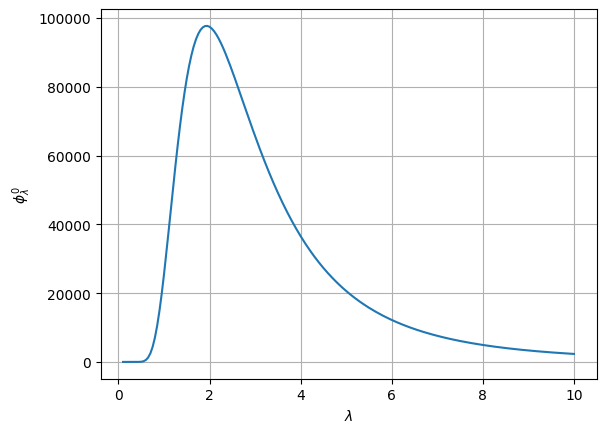

In [6]:
plt.plot(x, phi)
plt.ylabel(r'$\phi_{\lambda}^0$')
plt.xlabel(r'$\lambda$')
plt.grid()
plt.show()

### Densité de flux totale émise par le corps noir

La densité de flux totale émise par le corps noir se calcule en intégrant la loi de Planck sur l’espace des longueurs d’onde et s’exprime en W.m−2 :
$$
\phi^0 \left(T\right) = \int_0^{+\infty} \phi_{\lambda}^0(T) d \lambda
$$

La solution analytique est donnée par : 
$$
\phi^0 \left(T\right) = \sigma T^4
$$
Avec $\sigma = 5.67.10^{-8} W.m^{-2}.K^{-4}$

A l'aide de la fonction `scipy.integrate.quad` calculer $\phi^0 \left(T\right)$ pour T = 300 K, T = 1500 K et T = 5780 K. Comparer avec la solution analytique. Quelle remarque peut-on faire sur l'erreur relative d'approximation ?

*PS: SciPy permet le calcul d'intégrales impropres, l'argument $\infty$* peut être appelé via `np.inf`

In [7]:
from scipy import integrate

sigma = 5.67*10**(-8)

for temp in [300, 1500, 5780]:
    print(f'Résultats pour T = {temp} K:')
    ana_val = sigma*temp**4
    num_val = integrate.quad(planck_law, 0, np.inf, args=(temp,))[0]
    rel_error = 100*abs(num_val-ana_val)/ana_val
    print('\tSolution analytique (W.m-2): {:.2f}\n\tApproximation numérique (W.m-2): {:.2f}\n\tErreur relative (%): {:.3f}'.format(ana_val, num_val, rel_error))
    print('*****')

Résultats pour T = 300 K:
	Solution analytique (W.m-2): 459.27
	Approximation numérique (W.m-2): 459.30
	Erreur relative (%): 0.006
*****
Résultats pour T = 1500 K:
	Solution analytique (W.m-2): 287043.75
	Approximation numérique (W.m-2): 287061.75
	Erreur relative (%): 0.006
*****
Résultats pour T = 5780 K:
	Solution analytique (W.m-2): 63284071.50
	Approximation numérique (W.m-2): 63288040.87
	Erreur relative (%): 0.006
*****


## Produit de convolution

La notion de produit de convolution vous a été introduite cette année lors des cours de maths. Pour rappel, soit $f$ et $g$ deux fonctions définies sur $\mathbb{R}$. Sous réserve d'existence, on définit le produit de convolution de $f$ et $g$ comme la fonction :
$$
f * g : t \longrightarrow \int_{-\infty}^{+\infty} f(\tau) g(t-\tau) ~ d \tau.
$$

Dans l'exercice I.14, nous avons déterminé le produit de convolution $f * f$ où :
$$
f : t \longrightarrow \left\{ \begin{array}{ll}
        1  & \text{si}~~ t \in [-a,~a],\\
        0 & \text{sinon}.
    \end{array}
    \right.
$$

A l'aide de la fonction `convolve`du module `signal` de SciPy, réaliser ce produit de convolution et afficher les résultats obtenus à l'aide de Matplotlib (en utilisant le module `subplot`).

*Vous pouvez utiliser la fonction `repeat` de NumPy afin de créer la fonction $f$*.

In [8]:
# On crée la fonction f avec une largeur de porte égale à 100 (a=50)
a=50
sig = np.repeat([0.,1.,0.], 2*a)
sig_x = np.linspace(-3*a, 3*a, sig.size)
# On réalise ensuite le produit de convolution de f avec elle même
filtered = signal.convolve(sig, sig)
filt_x = np.linspace(-6*a, 6*a, filtered.size)

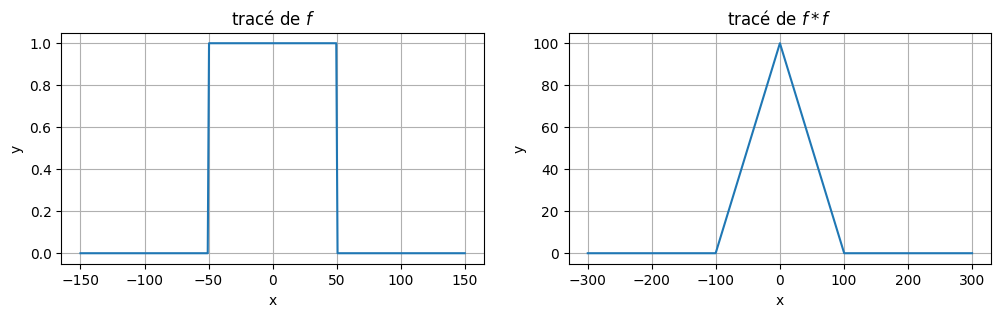

In [9]:
# On affiche f et f*f
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(sig_x, sig)
ax1.set_title(r'tracé de $f$')
ax1.set(xlabel='x', ylabel='y')
ax1.grid()
ax2.plot(filt_x, filtered)
ax2.set_title(r'tracé de $f*f$')
ax2.set(xlabel='x', ylabel='y')
ax2.grid()
plt.show()

## 🌶️ Calcul des pertes de charge régulières

Lors d'un écoulement d'un fluide dans une conduite et en l'absence de singularités (coude, obstacle...), celui-ci voit son énergie totale diminuer à cause des pertes visqueuses (frottement avec les canalisations). Cette quantité d'énergie perdue, qu'on appelle pertes de charge, peut être calculée via un bilan d'énergie sur la conduite (Th. de Bernoulli géné) :
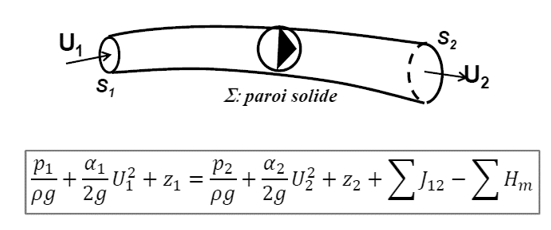
* $J_{12}$ : pertes de charge positive entre les deux sections.
* $H_m$ : hauteur manométrique des machines hydrauliques $\left(\frac{\dot{W}}{g.\dot{m}}\right)$.
* $\alpha$ : coefficient d'énergie cinétique, c'est un facteur de correction appliqué pour tenir compte de la forme réelle du profil de vitesse dans la conduite.

Il est possible de montrer que les pertes de charge peuvent se calculer via :
$$
J_{12} = \lambda \cdot \frac{L}{D_h} \cdot \frac{u^2}{2g}
$$

Où $\lambda$ représente le coefficient de pertes de charge de l'équation de Darcy-Weisbach, et qui se calcule dans le cas général via la formule implicite de Colebrook :
$$
\frac{1}{\sqrt{\lambda}} = -2\text{log} \left(\frac{\epsilon}{3.71D} + \frac{2.51}{\text{Re}\sqrt{\lambda}} \right)
$$
$$
\text{Re} = \frac{\rho u D_h}{\mu}
$$
Où $\epsilon$ est la rugosité de surface (en mm) dont l'effet est d'augmenter les pertes de charge, $D_h$ le diamètre hydraulique et $u$ la vitesse débitante au sein de la conduite.

A l'aide de `scipy.optimize.fsolve` et d'autres modules utiles de NumPy, implémenter un code qui permet de calculer le coefficient de pertes de charge avec comme données d'entrées : $\dot{m}, \rho, \mu, \epsilon, D_h$

In [40]:
from scipy.optimize import fsolve, newton

def colebrook_equation(lamb, reynolds, eps, d):
    """
    Colebrook equation for friction factor.

    Args:
    - lamn: friction factor
    - reynolds: Reynolds number
    - eps: rugosity of the pipe (m)
    - d: inner diameter of the canalisation (m) 

    Returns:
    - Residual value to be minimized
    """
    term_1 = 1.0/np.sqrt(lamb)
    term_2 = 2*np.log10((eps/(3.7*d))+(2.51/(reynolds*np.sqrt(lamb))))
    
    return term_1+term_2

def colebrook_friction_factor(m, rho, mu, eps, d):
    """
    Calculate the Darcy friction factor using the Colebrook equation.

    Parameters:
    - m: mass flow rate in the pipe (kg/s)
    - rho: fluid density (kg/m3)
    - mu: fluid dynamic viscosity (Pa.s)
    - eps: rugosity of the pipe (m)
    - d: inner diameter of the canalisation (m)

    Returns:
    - friction_factor (float): Darcy friction factor.
    """
    
    v = 4*m/(rho*(np.pi*d**2))
    re = rho*v*d/mu
    print('Velocity', v)
    print('Reynolds', re)

    # Initial guess for fsolve
    initial_guess = 0.01 # Initial guess for the friction factor

    # Solve using fsolve
    friction_factor_solution = fsolve(colebrook_equation, initial_guess, args=(re, eps, d))[0]

    return friction_factor_solution

# Example usage:
mass_flow_example = 23.5  # kg/s
diameter_example = 0.3  # m
rugosity_example = 0.0015  # m
viscosity_example = 0.001  # Pa.s
density_example = 1000  # kg/m^3

friction_factor_result = colebrook_friction_factor(
    m=mass_flow_example, 
    rho=density_example,
    mu=viscosity_example,
    eps=rugosity_example,
    d=diameter_example
)
print(f"The Darcy friction factor is: {friction_factor_result}")


Velocity 0.33245699223640357
Reynolds 99737.09767092105
The Darcy friction factor is: 0.031308757742079
